# setup

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [2]:
from vnstock import Listing, Quote, Company, Finance, Trading, Screener 

/opt/conda/envs/quant/lib/python3.12/site-packages/vnai/scope/profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# load data

In [3]:
def get_symbols_by_group(group_name):
    listing = Listing()
    return listing.symbols_by_group(group_name)

def fetch_history_for_symbols(symbols, start='2010-01-01', end='2025-08-25', interval='1D'):
    all_data = []
    for symbol in symbols:
        quote = Quote(symbol=symbol, source='VCI')
        df = quote.history(start=start, end=end, interval=interval)
        df['symbol'] = symbol
        all_data.append(df)
    result = pd.concat(all_data, ignore_index=True)
    result['time'] = pd.to_datetime(result['time'])
    return result

def save_to_csv(df, filepath):
    df.to_csv(filepath, index=False)
    print(f"Đã lưu dữ liệu vào {filepath}")

def filter_data_by_symbol(symbol, df, start=None, end=None):
    df.index = pd.to_datetime(df.index)
    if start is None:
        start = df.index.min()
    if end is None:
        end = df.index.max()
    return df[(df['symbol'] == symbol) & (df.index >= start) & (df.index <= end)]

In [4]:
# Fetch VN30F1M (nearest month VN30 futures) historical data using vnstock
vn30f1m_quote = Quote(symbol='VN30F1M', source='VCI')
vn30f1m_index = vn30f1m_quote.history(start='2018-01-01', end='2025-08-25', interval='1D')
vn30f1m_index['time'] = pd.to_datetime(vn30f1m_index['time'])
vn30f1m_index = vn30f1m_index.set_index('time')
vn30f1m_index.head()

,open,high,low,close,volume
time,,,,,
2018-01-02,983.9,999.0,980.8,999.0,11347
2018-01-03,1002.5,1015.2,1002.0,1012.8,16134
2018-01-04,1014.8,1023.9,1012.8,1023.9,13815
2018-01-05,1024.1,1025.0,1007.0,1012.0,16296
2018-01-08,1008.3,1031.0,1005.7,1030.0,13326


In [5]:
# Fetch VN30 index historical data using vnstock
vn30_quote = Quote(symbol='VN30', source='VCI')
vn30_index = vn30_quote.history(start='2010-01-01', end='2025-08-25', interval='1D')
vn30_index['time'] = pd.to_datetime(vn30_index['time'])
vn30_index = vn30_index.set_index('time')
vn30_index.head()

,open,high,low,close,volume
time,,,,,
2012-02-06,447.47,447.47,447.47,447.47,13467070
2012-02-07,449.31,449.31,449.31,449.31,17261070
2012-02-08,460.98,460.98,460.98,460.98,20406280
2012-02-09,464.73,464.73,464.73,464.73,20379320
2012-02-10,458.23,458.23,458.23,458.23,20816360


In [6]:
data_all = pd.read_csv('data/vn30_history.csv')
data_all = data_all.set_index('time')
data_all.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,3.71,3.97,3.69,3.97,2765900,ACB
2010-01-05,4.06,4.14,3.94,3.97,1929200,ACB
2010-01-06,3.96,4.01,3.86,3.86,1303300,ACB
2010-01-07,3.95,3.97,3.84,3.86,1342000,ACB
2010-01-08,3.87,4.01,3.80,3.83,1461300,ACB


In [7]:
df_hpg = filter_data_by_symbol('HPG',df=data_all)
df_hpg.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,1.47,1.49,1.47,1.49,603120,HPG
2010-01-05,1.56,1.56,1.49,1.56,1203080,HPG
2010-01-06,1.55,1.61,1.54,1.61,1771660,HPG
2010-01-07,1.64,1.68,1.61,1.66,1535800,HPG
2010-01-08,1.70,1.70,1.59,1.59,909010,HPG


# macd divergence

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- EMA theo chuẩn TradingView ---
def ema_tv(series: pd.Series, length: int) -> pd.Series:
    s = pd.Series(series, dtype='float64')
    alpha = 2.0 / (length + 1.0)
    ema = np.full(len(s), np.nan)

    # seed = close đầu tiên khác NaN
    i0 = np.where(~np.isnan(s.values))[0][0]
    ema[i0] = s.iloc[i0]

    for i in range(i0 + 1, len(s)):
        ema[i] = alpha * s.iloc[i] + (1 - alpha) * ema[i - 1]

    return pd.Series(ema, index=s.index)

# --- MACD chuẩn TradingView ---
def calculate_macd(series, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = ema_tv(series, fast_period)
    ema_slow = ema_tv(series, slow_period)
    macd = ema_fast - ema_slow
    signal = ema_tv(macd, signal_period)
    histogram = macd - signal
    return macd, signal, histogram

# --- Đỉnh/đáy cục bộ ---
def find_local_extrema(series, window=5):
    extrema = pd.DataFrame(index=series.index)
    extrema['peak'] = np.where(
        (series.shift(1) < series) & (series.shift(-1) < series) &
        (series.rolling(window=window).max().shift(-int(window/2)) == series),
        series, np.nan
    )
    extrema['trough'] = np.where(
        (series.shift(1) > series) & (series.shift(-1) > series) &
        (series.rolling(window=window).min().shift(-int(window/2)) == series),
        series, np.nan
    )
    return extrema

def find_macd_divergence(df, macd_fast=12, macd_slow=26, macd_signal=9, window=60):
    df = df.copy()
    df = df[df.index.dayofweek < 5]  # bỏ T7, CN

    # tính MACD
    df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(
        df['close'], macd_fast, macd_slow, macd_signal
    )

    # cực trị giá và histogram
    price_extrema = find_local_extrema(df['close'])
    hist_extrema = find_local_extrema(df['macd_hist'])

    bullish_divergence = []
    bearish_divergence = []

    for i in range(window, len(df)):
        # --- Bullish divergence ---
        troughs_price = price_extrema['trough'].iloc[i-window:i].dropna()
        troughs_hist  = hist_extrema['trough'].iloc[i-window:i].dropna()

        if len(troughs_price) >= 2 and len(troughs_hist) >= 2:
            for t1 in troughs_price.index[:-1]:
                for t2 in troughs_price.index[1:]:
                    if t2 <= t1:  # phải sau
                        continue
                    if t1 not in troughs_hist.index or t2 not in troughs_hist.index:
                        continue
                    
                    h1, h2 = hist_extrema.loc[t1, 'trough'], hist_extrema.loc[t2, 'trough']
                    
                    # giá giảm nhưng hist tăng
                    if df.loc[t2, 'close'] < df.loc[t1, 'close'] and h2 > h1:
                        # có ít nhất 1 đỉnh dương ở giữa
                        if (df.loc[t1:t2, 'macd_hist'] > 0).any():
                            bullish_divergence.append(t2)

        # --- Bearish divergence ---
        peaks_price = price_extrema['peak'].iloc[i-window:i].dropna()
        peaks_hist  = hist_extrema['peak'].iloc[i-window:i].dropna()

        if len(peaks_price) >= 2 and len(peaks_hist) >= 2:
            for p1 in peaks_price.index[:-1]:
                for p2 in peaks_price.index[1:]:
                    if p2 <= p1:
                        continue
                    if p1 not in peaks_hist.index or p2 not in peaks_hist.index:
                        continue
                    
                    h1, h2 = hist_extrema.loc[p1, 'peak'], hist_extrema.loc[p2, 'peak']
                    
                    # giá tăng nhưng hist giảm
                    if df.loc[p2, 'close'] > df.loc[p1, 'close'] and h2 < h1:
                        # có ít nhất 1 đoạn âm ở giữa
                        if (df.loc[p1:p2, 'macd_hist'] < 0).any():
                            bearish_divergence.append(p2)

    return (
        pd.DataFrame(index=pd.to_datetime(bullish_divergence)),
        pd.DataFrame(index=pd.to_datetime(bearish_divergence)),
        df
    )


# --- Visualization ---
def visualize_divergence(df, bullish_signals, bearish_signals, window=100):
    df = df[df.index.dayofweek < 5]  # bỏ T7, CN

    if 'macd_hist' not in df.columns:
        df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['close'])

    price_extrema = find_local_extrema(df['close'])
    hist_extrema = find_local_extrema(df['macd_hist'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12),
                                    sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # giá
    ax1.set_title('Giá & Divergence (MACD Histogram)', fontsize=16)
    ax1.plot(df.index, df['close'], label='Giá', color='blue')
    ax1.scatter(price_extrema.index, price_extrema['peak'], marker='^', color='red', s=100)
    ax1.scatter(price_extrema.index, price_extrema['trough'], marker='v', color='green', s=100)

    # MACD hist
    ax2.set_title('MACD Histogram', fontsize=16)
    ax2.bar(df.index, df['macd_hist'], color='grey', alpha=0.6)
    ax2.plot(df.index, df['macd'], label='MACD', color='blue')
    ax2.plot(df.index, df['macd_signal'], label='Signal', color='red', linestyle='--')
    ax2.axhline(0, color='black', linewidth=1)

    ax2.scatter(hist_extrema.index, hist_extrema['peak'], marker='^', color='red', s=100)
    ax2.scatter(hist_extrema.index, hist_extrema['trough'], marker='v', color='green', s=100)

    # Divergences
    for date in bullish_signals.index:
        idx = df.index.get_loc(date)
        troughs_in_range = price_extrema['trough'].iloc[idx-window:idx+1].dropna()
        if len(troughs_in_range) >= 2:
            t1, t2 = troughs_in_range.index[-2], troughs_in_range.index[-1]
            ax1.plot([t1, t2], [df.loc[t1, 'close'], df.loc[t2, 'close']], color='green', linewidth=2)
            ax2.plot([t1, t2], [df.loc[t1, 'macd_hist'], df.loc[t2, 'macd_hist']], color='green', linewidth=2)

    for date in bearish_signals.index:
        idx = df.index.get_loc(date)
        peaks_in_range = price_extrema['peak'].iloc[idx-window:idx+1].dropna()
        if len(peaks_in_range) >= 2:
            p1, p2 = peaks_in_range.index[-2], peaks_in_range.index[-1]
            ax1.plot([p1, p2], [df.loc[p1, 'close'], df.loc[p2, 'close']], color='red', linewidth=2)
            ax2.plot([p1, p2], [df.loc[p1, 'macd_hist'], df.loc[p2, 'macd_hist']], color='red', linewidth=2)

    plt.tight_layout()
    return fig, ax1, ax2


In [73]:
bullish, bearish, df_res = find_macd_divergence(df_hpg,window=100)

print("Bullish divergence days:")
print(bullish.index.strftime("%Y-%m-%d").unique().tolist())

print("Bearish divergence days:")
print(bearish.index.strftime("%Y-%m-%d").unique().tolist())

Bullish divergence days:
['2010-06-21', '2010-08-12', '2010-08-25', '2011-04-22', '2011-05-25', '2011-06-20', '2011-07-01', '2011-07-12', '2011-08-12', '2011-09-06', '2011-09-21', '2011-09-27', '2011-12-27', '2012-08-02', '2012-08-16', '2012-08-27', '2012-09-28', '2012-10-15', '2014-10-27', '2014-11-06', '2014-11-28', '2015-03-19', '2015-06-05', '2015-06-26', '2015-07-15', '2015-12-10', '2017-03-17', '2017-03-28', '2018-05-28', '2019-01-08', '2019-02-01', '2019-04-18', '2019-06-27', '2019-07-19', '2019-07-30', '2021-08-27', '2021-12-23', '2022-01-11', '2022-03-31', '2022-05-09', '2022-05-25', '2022-06-02', '2022-06-15', '2022-06-21', '2022-07-06', '2022-08-31', '2022-10-24', '2022-11-01', '2022-11-23', '2023-01-13', '2023-03-20', '2023-10-19', '2023-10-26', '2024-09-05', '2024-09-16', '2025-01-22', '2025-05-12', '2025-05-29', '2025-06-11']
Bearish divergence days:
['2010-12-02', '2012-04-05', '2012-04-25', '2012-06-18', '2012-12-25', '2013-02-18', '2013-03-15', '2013-03-26', '2013-05-1

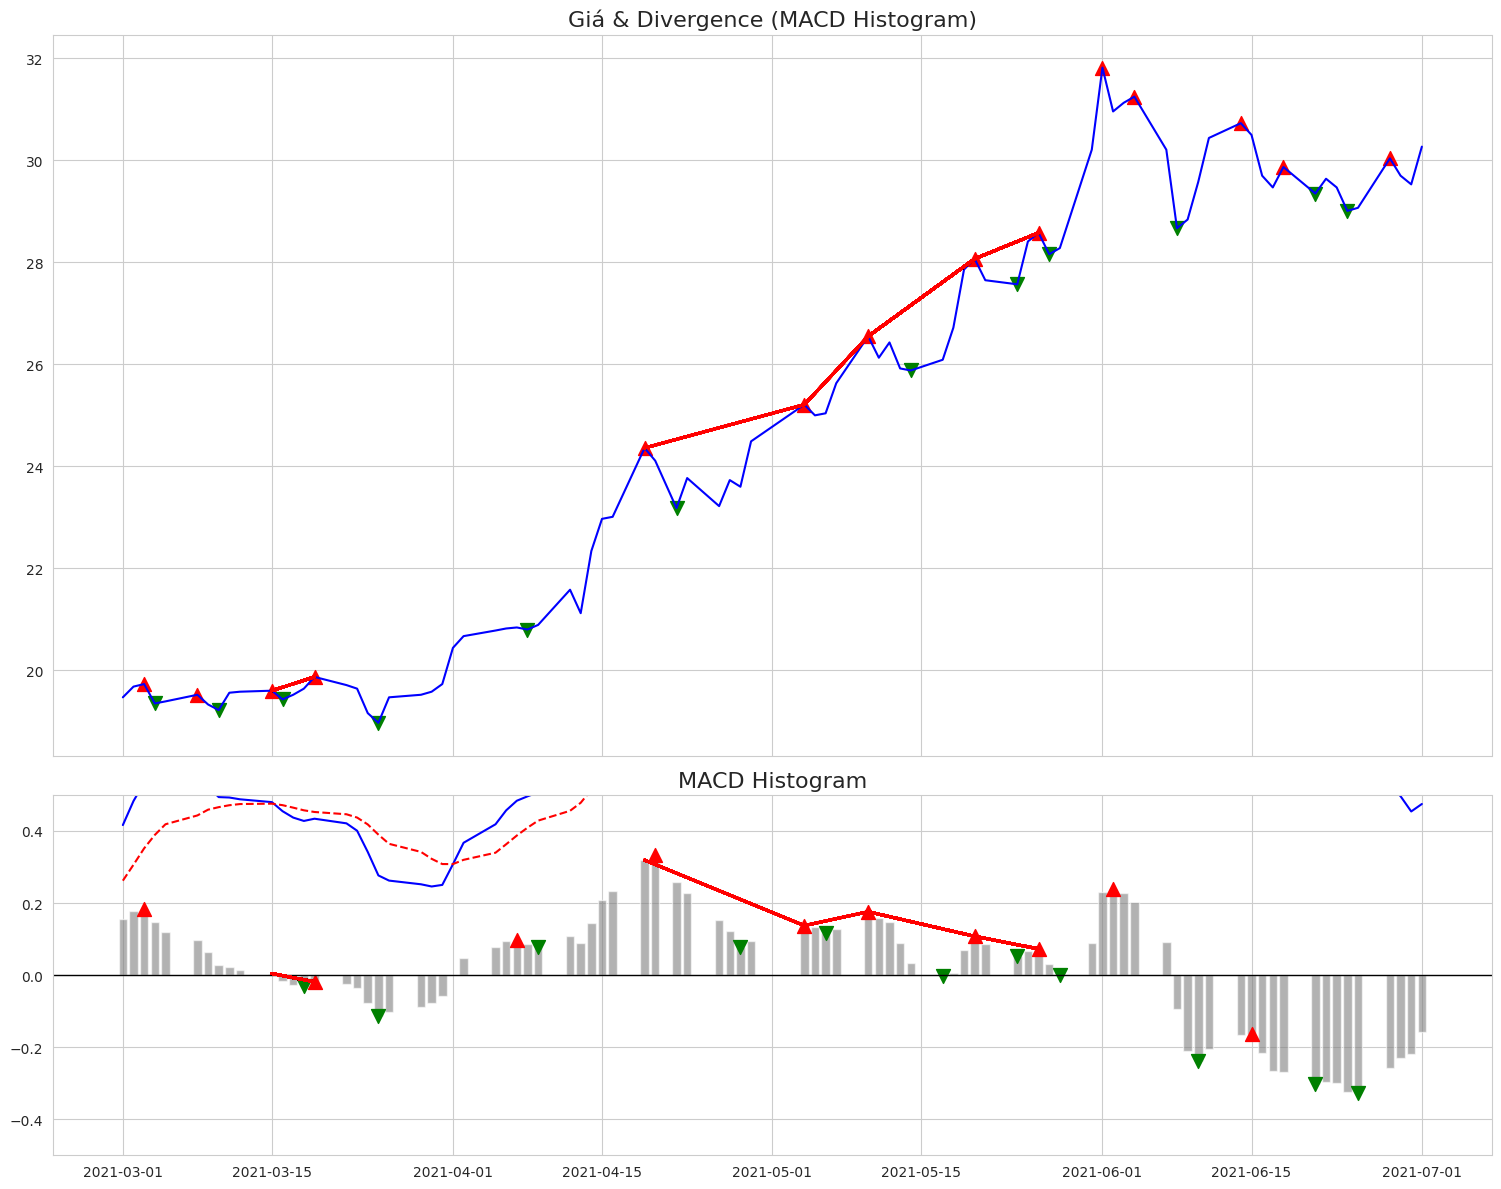

In [76]:
# ...existing code...
start_date = "2021-03-01"
end_date = "2021-07-01"

df_res_filtered = df_res.loc[start_date:end_date]
bullish_filtered = bullish.loc[(bullish.index >= start_date) & (bullish.index <= end_date)]
bearish_filtered = bearish.loc[(bearish.index >= start_date) & (bearish.index <= end_date)]

fig, ax1, ax2 = visualize_divergence(df_res_filtered, bullish_filtered, bearish_filtered)

# ax1.set_ylim(23, 30)
ax2.set_ylim(-0.5, 0.5)

plt.show()
# ...existing code...